In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [9]:
# Training Params
num_steps = 20000
batch_size = 32

# Network Params
image_dim = 784 # 28*28 pixels * 1 channel
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 200 # Noise data points

In [4]:
# Generator Network
# Input: Noise, Output: Image
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        # TensorFlow Layers automatically create variables and calculate their
        # shape, based on the input.
        x = tf.layers.dense(x, units=6 * 6 * 128)
        x = tf.nn.tanh(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 6, 6, 128)
        x = tf.reshape(x, shape=[-1, 6, 6, 128])
        # Deconvolution, image shape: (batch, 14, 14, 64)
        x = tf.layers.conv2d_transpose(x, 64, 4, strides=2)
        # Deconvolution, image shape: (batch, 28, 28, 1)
        x = tf.layers.conv2d_transpose(x, 1, 2, strides=2)
        # Apply sigmoid to clip values between 0 and 1
        x = tf.nn.sigmoid(x)
        return x


# Discriminator Network
# Input: Image, Output: Prediction Real/Fake Image
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Typical convolutional neural network to classify images.
        x = tf.layers.conv2d(x, 64, 5)
        x = tf.nn.tanh(x)
        x = tf.layers.average_pooling2d(x, 2, 2)
        x = tf.layers.conv2d(x, 128, 5)
        x = tf.nn.tanh(x)
        x = tf.layers.average_pooling2d(x, 2, 2)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024)
        x = tf.nn.tanh(x)
        # Output 2 classes: Real and Fake images
        x = tf.layers.dense(x, 2)
    return x

# Build Networks
# Network Inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])

# Build Generator Network
gen_sample = generator(noise_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample, reuse=True)
disc_concat = tf.concat([disc_real, disc_fake], axis=0)

# Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

# Build Targets (real or fake images)
disc_target = tf.placeholder(tf.int32, shape=[None])
gen_target = tf.placeholder(tf.int32, shape=[None])

# Build Loss
disc_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_concat, labels=disc_target))
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=gen_target))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=0.001)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=0.001)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# Discriminator Network Variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

In [10]:
# Initializing all variables
init = tf.global_variables_initializer()

# Launch the graph
sess = tf.Session()
sess.run(init)

# Training
for i in range(1, num_steps+1):

    # Prepare Input Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Prepare Targets (Real image: 1, Fake image: 0)
    # The first half of data fed to the generator are real images,
    # the other half are fake images (coming from the generator).
    batch_disc_y = np.concatenate(
        [np.ones([batch_size]), np.zeros([batch_size])], axis=0)
    # Generator tries to fool the discriminator, thus targets are 1.
    batch_gen_y = np.ones([batch_size])

    # Training
    feed_dict = {real_image_input: batch_x, noise_input: z,
                 disc_target: batch_disc_y, gen_target: batch_gen_y}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 0.681313, Discriminator Loss: 0.696048
Step 1000: Generator Loss: 4.661900, Discriminator Loss: 0.159617
Step 2000: Generator Loss: 5.742433, Discriminator Loss: 0.090844
Step 3000: Generator Loss: 6.892461, Discriminator Loss: 0.026230
Step 4000: Generator Loss: 5.020532, Discriminator Loss: 0.015655
Step 5000: Generator Loss: 5.856355, Discriminator Loss: 0.103759
Step 6000: Generator Loss: 5.562930, Discriminator Loss: 0.133212
Step 7000: Generator Loss: 4.755675, Discriminator Loss: 0.011252
Step 8000: Generator Loss: 4.523346, Discriminator Loss: 0.107898
Step 9000: Generator Loss: 4.274240, Discriminator Loss: 0.059357
Step 10000: Generator Loss: 5.600301, Discriminator Loss: 0.092585
Step 11000: Generator Loss: 4.123196, Discriminator Loss: 0.137491
Step 12000: Generator Loss: 3.959795, Discriminator Loss: 0.080210
Step 13000: Generator Loss: 2.617940, Discriminator Loss: 0.165060
Step 14000: Generator Loss: 3.607795, Discriminator Loss: 0.147673
Step 150

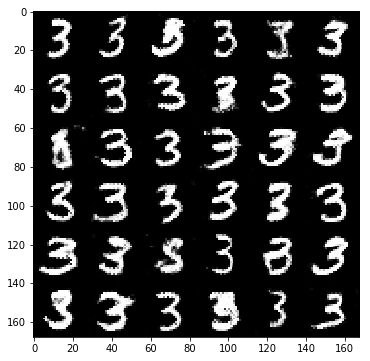

In [12]:
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run([gen_sample], feed_dict={noise_input: z})
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()